<div style="background-color: black; color: white; padding: 10px;text-align: center;">
  <strong>Date Published:</strong> June 03, 2025 <strong>Author:</strong> Adnan Alaref
</div>

# 🧼 Denoising Autoencoder (DAE)

>A **Denoising Autoencoder (DAE)** is a type of autoencoder neural network designed not only to compress and reconstruct input data, but also to learn **robust representations** by removing noise from corrupted input data. It is an **unsupervised learning model** introduced by *Vincent et al. (2008)* to improve the ability of autoencoders to learn meaningful latent structures.

---

## 🧠 Key Idea

>DAEs are trained to recover the original clean input **`x`** from a corrupted version **`x̃`**.  
This forces the network to learn stable, noise-invariant features, instead of simply memorizing the input.

**Formal Pipeline:**

$$
x → (corruption) → x̃ → Encoder → h → Decoder → x̂ ≈ x
$$

Where:

- `x`: Original input  
- `x̃`: Noisy version of input  
- `h`: Latent (compressed) representation  
- `x̂`: Reconstructed (cleaned) output

---

## 🧪 Corruption Techniques 

> We Implement each techniqe bleow.
The corruption step is *intentional* and helps the model generalize:

- **Gaussian Noise**  
  Add small random noise:  
  $$
  x̃ = x + ϵ, where ϵ ∼ 𝒩(0, σ^2)
  $$

- **Masking Noise**  
  Randomly set some input values to 0.

- **Salt-and-Pepper Noise**  
  Randomly set some pixel values to 1 or 0 (used in image denoising).

---

## 🏗️ Architecture

A DAE consists of two main parts:

### 1. Encoder
Maps the noisy input `x̃` to a latent space `h`:

$$
h = f_θ(x̃) = σ(Wx̃ + b)
$$

### 2. Decoder
Reconstructs the original clean input from `h`:

$$
x̂ = g_θ(h) = σ(W' h + b')
$$

Parameters `θ = {W, b, W', b'}` are optimized to minimize reconstruction error.

---

## 📉 Loss Function

Two common loss functions depending on the data type:

- **Mean Squared Error (MSE)**  
  $$
  L(x, x̂) = ∥x - x̂∥²
  $$

- **Binary Cross-Entropy (BCE)** (for binary or [0,1] inputs)  
  $$
  L(x, x̂) = - ∑ [x log(x̂) + (1 - x) log(1 - x̂)]
  $$

---

## ✅ Why Use Denoising Autoencoders?

- **Feature robustness**: Learns to ignore irrelevant noise and extract meaningful patterns.
- **Improved generalization**: Avoids overfitting by learning noise-invariant features.
- **Data denoising**: Cleans corrupted inputs (e.g., blurry or noisy images).
- **Pretraining**: Can initialize deep networks (greedy layer-wise training).

---

## 📦 Example Use Cases

- Image denoising (removing blur, scratches, artifacts)
- Text denoising (e.g., OCR error correction)
- Speech enhancement (cleaning noisy audio)
- Pretraining layers for deep neural networks

---
>Let's Code...

# **◍ Step 1: Import Libraries .:.**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore' ,category=FutureWarning)

# **◍ Step 2: Add Corruption (three wayes to do that) .:.**

### **The corruption step is intentional and can be applied in various ways, such as:**

- **Gaussian noise**: Add small random noise :  xˇ = x + ϵ , where \(ϵ ∼ 𝑵(0, σ^2)

- **Masking noise**: Randomly set some input values to 0.

- **Salt-and-pepper noise**: Randomly set values to 1 or 0 (used in image denoising).

In [2]:
# Original tensor with 4 values
x = torch.tensor([[0.2, 0.5, 0.9, 0.3]])
print(f"Tensor before applay any noise: {x}")

#-----------------------------
# 1. Gaussian Noise
#-----------------------------
'''
👉 Add small random Gaussian noise to each element in the tensor
torch.randn_like(x) generates random numbers from N(0,1) with same shape as x
Multiply by 0.1 to scale noise to N(0, 0.1^2)
'''
noise_gauss = torch.randn_like(x) * 0.1 # ε ~ N(0, 0.01)
x_gauss_noisy = x + noise_gauss         # Add noise element-wise
print(f"Gaussian Noise: {x_gauss_noisy}")

#-----------------------------
# 2. Masking Noise
#-----------------------------
'''
👉 Randomly zero out some elements of the tensor (simulate missing data)
torch.rand_like(x) generates uniform random numbers between 0 and 1
Create a mask where ~70% of values are kept (mask=1), and ~30% are zeroed out (mask=0)
'''
mask = (torch.rand_like(x) > 0.3).float()
print("Mask ", mask)
x_mask_noisy = x * mask # Element-wise multiply to zero out masked elements
print(f"Masking Noise: {x_mask_noisy}")


#-----------------------------
# 3. Salt-and-Pepper Noise
#-----------------------------
# 👉 Randomly replace some elements by 0 (pepper) or 1 (salt)
rand = torch.rand_like(x)                  # Uniform random values [0,1]
x_salt_pepper = x.clone()                  # Create a copy to avoid modifying original tensor
x_salt_pepper[rand < 0.05] = 0.0           # Set ~5% of values to 0 (pepper noise)
x_salt_pepper[rand > 0.95] = 1.0           # Set ~5% of values to 1 (salt noise)
print(f"Salt-and-Pepper Noise: {x_salt_pepper}")

Tensor before applay any noise: tensor([[0.2000, 0.5000, 0.9000, 0.3000]])
Gaussian Noise: tensor([[0.1928, 0.3559, 0.9731, 0.4331]])
Mask  tensor([[1., 0., 1., 0.]])
Masking Noise: tensor([[0.2000, 0.0000, 0.9000, 0.0000]])
Salt-and-Pepper Noise: tensor([[0.2000, 0.5000, 0.9000, 0.3000]])


# **◍ Step 3: Denoising AutoEncoder Simple Implemintaion .:.**

In [3]:
class dnoiseautoencoder(nn.Module):
  def __init__(self,input_dim,hidden_dim):
    super(dnoiseautoencoder,self).__init__()

    # Setup encoder
    self.encoder = nn.Sequential(
        nn.Linear(input_dim ,hidden_dim),
        nn.ReLU()
        ## add rest layers
    )

    # Setup decoder
    self.decoder = nn.Sequential(
        nn.Linear(hidden_dim ,input_dim),
        ## add rest layers
        nn.Sigmoid()
    )

    # Setup forward
    def forward(self,x_noisy):
      encoded = self.encoder(x_noisy)
      decoded = self.decoder(encoded)
      return decoded

# **◍ Step 4: Full Example For Using Denoising Autoencoder .:.**

In [4]:
# -------------------------------------
# 1. Hyperparameters
# -------------------------------------
Train_BATCH_SIZE = 128
Test_BATCH_SIZE = 128
NOISE_STD = 0.3
EPOCHS = 10
LR = 1e-3


# -------------------------------------
# 2. Data Preparation (MNIST)
# -------------------------------------
transform = transforms.Compose([
        transforms.ToTensor(),# converts to [0, 1]
])
train_dataset = datasets.MNIST(root = './data', train=True, download=True, transform = transform)
test_dataset = datasets.MNIST(root = './data', train =False, download  =True,transform = transform)

train_loader = DataLoader(train_dataset, batch_size=Train_BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Test_BATCH_SIZE, shuffle=False)

# -------------------------------------
# 3. Denoising Autoencoder Model
# -------------------------------------
class DnoiseAutoencoder(nn.Module):
  def __init__(self):
    super(DnoiseAutoencoder,self).__init__()
    # Input (784) → Hidden (128) → Hidden (64) → Latent (32) → Hidden (64) → Hidden (128) → Output (784)
    # Setup encoder
    self.encoder = nn.Sequential(
        nn.Linear(28*28,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,32),
        nn.ReLU()
    )
    # Setup Decoder
    self.decoder = nn.Sequential(
        nn.Linear(32,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,28*28),
        nn.Sigmoid() # because output should be in [0, 1]
    )
  # Forward function
  def forward(self, x_noisy):
    encoded = self.encoder(x_noisy)
    decoded = self.decoder(encoded)
    return decoded


# -------------------------------------
# 4. Add Gaussian Noise Function
# -------------------------------------
def add_gussian_noise(x, std):
  noise = torch.randn_like(x) * std
  x_noisy = x + noise
  return x_noisy.clamp(0,1) # Keep values in [0, 1]


# -------------------------------------
# 5. Setup Loss and Optimizer
# -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DAE_Model = DnoiseAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=DAE_Model.parameters(), lr=LR)
train_losses = []
test_losses = []
'''
Note:why using nn.MSELoss() not nn.BCELoss()
The output is not a label, it’s a vector of real-valued pixels like:
        input:      [0.2, 0.9, 0.1, 0.7]  ← original clean image
        prediction: [0.18, 0.85, 0.15, 0.68]  ← model tries to match this
'''


# -------------------------------------
# 6. Training Loop
# -------------------------------------
for epoch in range(EPOCHS):
  # Set Model In Traing Mode
  DAE_Model.train()
  total_train_loss = 0

  for images,_ in train_loader: # images = images.view(BATCH_SIZE, 784) -1 == 1 × 28 × 28 = 784
    images = images.view(images.shape[0] ,-1).to(device) # Flatten: [B, 784], Because a linear autoencoder takes 1D input
    noise_images = add_gussian_noise(images, NOISE_STD)

    # 1- Forward pass
    model_outputs = DAE_Model(noise_images)

    # 2- Claculate the loss (target ,ground_truth)
    train_loss = criterion(model_outputs, images) # Compare with original clean images

    # 3- Optimizer zero_grad
    optimizer.zero_grad()

    # 4- Backpropagation Loss backword
    train_loss.backward()

    # 5- Optimizer step(gradent descent)
    optimizer.step()
    total_train_loss += train_loss.item()

    # --- EVALUATE ON TEST SET ---
    # Set Model In Testing Mode
    DAE_Model.eval()
    total_test_loss = 0
    with torch.inference_mode():
      for images,_ in test_loader:
        test_images = images.view(images.shape[0] ,-1).to(device) # Flatten: [B, 784], Because a linear autoencoder takes 1D input
        noise_test_images = add_gussian_noise(test_images, NOISE_STD)

        # 1- Forward pass
        test_outputs = DAE_Model(noise_test_images)

        # 2- Clac Loss
        test_loss = criterion(test_outputs ,test_images)
        total_test_loss +=  test_loss.item()

  # Save all losses in train,test
  train_losses.append(total_train_loss)
  test_losses.append(total_test_loss)

  # Show resultes per epoch
  avg_train_loss = total_train_loss / len(train_loader)
  avg_test_loss = total_test_loss / len(test_loader)
  print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.80MB/s]


Epoch [1/10] - Train Loss: 0.0662 - Test Loss: 0.0485
Epoch [2/10] - Train Loss: 0.0379 - Test Loss: 0.0322
Epoch [3/10] - Train Loss: 0.0299 - Test Loss: 0.0278
Epoch [4/10] - Train Loss: 0.0268 - Test Loss: 0.0252
Epoch [5/10] - Train Loss: 0.0246 - Test Loss: 0.0234
Epoch [6/10] - Train Loss: 0.0227 - Test Loss: 0.0214
Epoch [7/10] - Train Loss: 0.0213 - Test Loss: 0.0201
Epoch [8/10] - Train Loss: 0.0199 - Test Loss: 0.0190
Epoch [9/10] - Train Loss: 0.0190 - Test Loss: 0.0181
Epoch [10/10] - Train Loss: 0.0184 - Test Loss: 0.0176


# **◍ Step 5: Testing and visualization .:.**

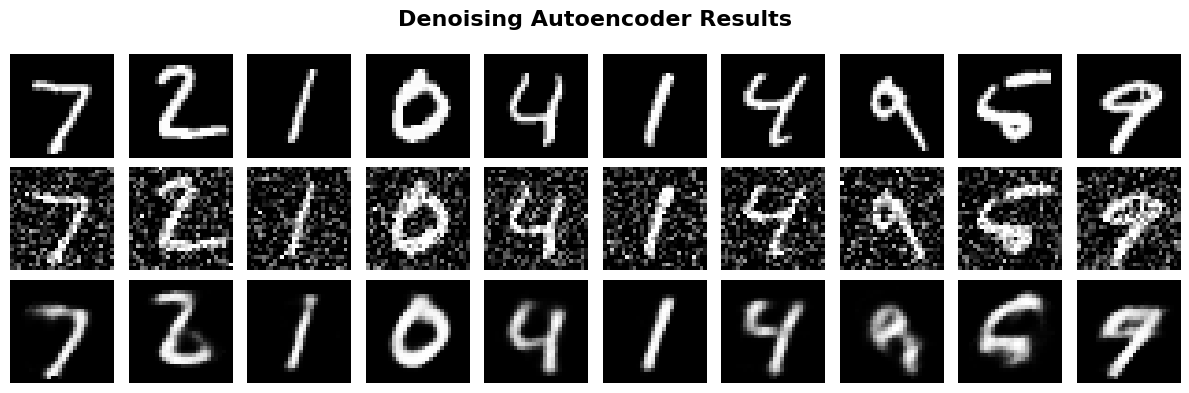

In [5]:
# -------------------------------------
# 7. Testing and visualization
# -------------------------------------
def show_images(orignal, noise, reconstructd, num):
  # Note: Matplotlib not work in GPU convert to CPU
  orignal = orignal.view(-1,1,28,28).cpu()
  noise = noise.view(-1,1,28,28).cpu()
  reconstructd = reconstructd.view(-1,1,28,28).cpu().detach() # detach because the output is part of the computation graph.

  fig ,axes = plt.subplots(nrows=3 ,ncols=10,figsize = (12,4))
  fig.suptitle('Denoising Autoencoder Results', fontweight = 'bold', fontsize=16)

  for i in range(num):
    # Original
    axes[0][i].imshow(orignal[i][0], cmap = 'gray') # [28,28]
    axes[0][i].axis('off')

    # Noisy
    axes[1][i].imshow(noise[i][0], cmap = 'gray')
    axes[1][i].axis('off')

    # Reconstructed
    axes[2][i].imshow(reconstructd[i][0], cmap = 'gray')
    axes[2][i].axis('off')

  axes[0][0].set_ylabel("Clean", fontsize=12)
  axes[1][0].set_ylabel("Noisy", fontsize=12)
  axes[2][0].set_ylabel("Denoised", fontsize=12)

  plt.tight_layout()
  plt.show()


# Sample Visualization
DAE_Model.eval()
with torch.inference_mode():
    test_images,_ = next(iter(test_loader))
    sample_images = test_images.view(test_images.shape[0], -1).to(device)
    sample_noise_images = add_gussian_noise(sample_images, NOISE_STD)
    reconstructed = DAE_Model(sample_noise_images)


show_images(test_images, sample_noise_images, reconstructed, 10)

### ✅ Final Summary

| **Tensor**       | **Comes From**             | **Correct Handling**                    |
|------------------|-----------------------------|------------------------------------------|
| `orignal`        | `next(iter(test_loader))`   | `.view(B, -1).cpu()`                     |
| `noise`          | `orignal + noise`           | `.view(B, -1).cpu()`                     |
| `reconstructd`   | `model(noise)`              | `.view(B, -1).cpu().detach()`← **important!** |

---


<a id="Import"></a>
<p style="background-color: #000000; font-family: 'Verdana', sans-serif; color: #FFFFFF; font-size: 160%; text-align: center; border-radius: 25px; padding: 12px 20px; margin-top: 20px; border: 2px solid transparent; background-image: linear-gradient(black, black), linear-gradient(45deg, #FF00FF, #00FFFF, #FFFF00, #FF4500); background-origin: border-box; background-clip: content-box, border-box; box-shadow: 0px 4px 20px rgba(255, 105, 180, 0.8);">
   Thanks & Upvote ❤️</p>